In [11]:
import torch
torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image as Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from torchvision import transforms
from scipy.ndimage import gaussian_filter
import cv2

There is a difference between OpenCV addition and Numpy addition. OpenCV addition is a saturated operation while Numpy addition is a modulo operation.

In [12]:
class BlendNet(nn.Module):
  def __init__(self, alpha):
    super(BlendNet, self).__init__()
    self.alpha = nn.Parameter(alpha)
    #self.alpha = alpha
  

  def forward(self, bg_img, fg_img, y1, y2, x1, x2):
    rows,cols,channels = fg_img.shape
    # tensor = torch.tensor((),  dtype=torch.uint8)
    # one = tensor.new_ones(fg_img.shape)
    # beta = one - self.alpha
    beta = 1.0 - self.alpha 
    bg_img[y1:y2,x1:x2] = torch.mul(fg_img[y1:y2,x1:x2], self.alpha) + torch.mul(bg_img[y1:y2,x1:x2], beta)
    
    # put outside the function
#     tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.uint8)))
#     bg_img[y1:y2,x1:x2] = tr(bg_img[y1:y2,x1:x2])
    bg_img[y1:y2,x1:x2] = bg_img[y1:y2,x1:x2]
    
#     detectron_output = loaded_predictor(bg_img.numpy())
#     scores = detectron_output["instances"].scores
    # tensor float32
    return bg_img

fg shape torch.Size([683, 1024, 3])
bg shape torch.Size([683, 1024, 3])
<class 'torch.Tensor'>


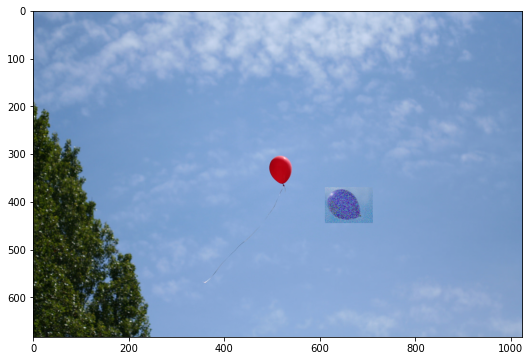

In [10]:
# # Load
path1 = '/home/prajwala/images/original.jpg'
path2 = '/home/prajwala/images/balloon2.jpg'
img_fg = Image.open(path2)
img_bg = Image.open(path1)
y1,y2,x1,x2 = [370,445,610,710]

# Convert to tensor and change dtype
tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.float32)))
img_fg = tr(img_fg)
img_bg = tr(img_bg)

print("fg shape",img_fg.shape)
print("bg shape",img_bg.shape)

alpha_tensor = torch.rand(size=(75,100,3))

model = BlendNet(alpha=alpha_tensor)
result = model(img_bg, img_fg, y1,y2,x1,x2)
print(type(result))

fig = figure(figsize=(10,6))
plt.imshow(result.detach().numpy().astype(np.uint8))
plt.show()

# res = loaded_predictor(result.numpy()) 
# print(res["instances"].scores)

In [13]:
# patch : coordinates of the perturbation
# boxes : list of coordinates of all detected boxes [[x1,y1,x2,y2]] top left and bottom right coordinates
import math
def get_closest_box(patch, boxes):
    min_dist = float('inf')
    
    p_x1, p_y1, p_x2, p_y2 = patch
    idx = 0
    
    for i,box in enumerate(boxes):
        b_x1, b_y1, b_x2, b_y2 = box
        
        dist1 = math.sqrt(
                            (b_x1 - p_x1)**2 + (b_y1 - p_y1)**2
                            )
        dist2 = math.sqrt(
                            (b_x2 - p_x2)**2 + (b_y2 - p_y2)**2
                            )
        l2dist = dist1 + dist2
        if l2dist < min_dist:
            min_dist = l2dist
            idx = i
            
    return idx
    

In [9]:

patch = [0,2,2,4]
boxes = [[1,1,3,3],[0,3,1,4]]

print(get_closest_box(patch, boxes))

1


In [17]:
def train_blendnet(path1, path2, patch, init_alpha, y1,y2,x1,x2):

    img_fg = Image.open(path2)
    img_bg = Image.open(path1)

    # Convert to tensor and change dtype
#     tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.uint8)))
    tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.float32)))
    img_fg = tr(img_fg)
    img_bg = tr(img_bg)

    print("fg shape",img_fg.shape)
    print("bg shape",img_bg.shape)


    model = BlendNet(alpha=init_alpha)

    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
    epochs =  100
    # print(f'alpha before backprop:{list(model.parameters)}')

    alpha_history = []

    for i in range(epochs):

        model_output = model(img_bg, img_fg,y1,y2,x1,x2)
        res = loaded_predictor(model_output.detach().numpy())

        # get the closest box to added patch
        boxes_list = res["instances"].get('pred_boxes')

        idx = get_closest_box(patch, boxes_list)

        scores = torch.tensor(res["instances"].scores[idx].cpu().numpy(), requires_grad = True)

        if i%25 == 0:
            print(res["instances"].scores)
            print(scores)
            print(boxes_list)
            print(idx)

    #     optimizer.zero_grad()
        scores.backward()

        # changes the alpha
        optimizer.step()

        for p in model.parameters():
            if p.requires_grad:
                alpha_history.append(p.data)

        if scores < 0.5:
            break
    return alpha_history


In [15]:
def view_detectron_results(blended_img_path, out_file_name):
    img = cv2.imread(blended_img_path)
    outputs = loaded_predictor(img)
    v = Visualizer(im[:, :, ::-1],
                      metadata=balloon_metadata, 
                      scale=0.5, 
                      instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
      )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite('/home/prajwala/images/detectron_results/blendnet/'+out_file_name+'.jpg',out.get_image()[:, :, ::-1])

    file = '/home/prajwala/images/detectron_results/blendnet/'+out_file_name+'.jpg'
   
    res = cv2.imread(file)
    fig = figure(figsize=(10,6))
    print(file)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.show()

In [71]:
########### Man Image ##############
path1 = '/home/prajwala/images/horse_man.jpg'
path2 = '/home/prajwala/images/green_banana.jpg'
patch = [400,100,550,200]
init_alpha = torch.rand(size=(100,150,3))
y1,y2,x1,x2 = [100,200,400,550]
path2 = cv2.resize(src1, (150,100), interpolation = cv2.INTER_AREA)

alpha_history = train_blendnet(path1, path2, patch, init_alpha,y1,y2,x1,x2)

model = BlendNet(alpha=alpha_history[-1])

img_fg = Image.open(path2)
img_bg = Image.open(path1)
# Convert to tensor and change dtype
tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.uint8)))
img_fg = tr(img_fg)
img_bg = tr(img_bg)
result = model(img_bg, img_fg)
fig = figure(figsize=(10,6))
plt.imshow(result)

cv2.imwrite('/home/prajwala/images/blended_images/blendnet_out_horseman.jpg',result.numpy())
view_detectron_results('/home/prajwala/images/blended_images/blendnet_out_horseman.jpg', 'horseman_banana')

fg shape torch.Size([640, 428, 3])
bg shape torch.Size([480, 640, 3])


RuntimeError: The size of tensor a (28) must match the size of tensor b (150) at non-singleton dimension 1

fg shape torch.Size([683, 1024, 3])
bg shape torch.Size([683, 1024, 3])
tensor([0.9230], device='cuda:0')
tensor(0.9230, requires_grad=True)
Boxes(tensor([[493.9921, 303.1945, 540.3892, 366.6065]], device='cuda:0'))
0
tensor([0.9234, 0.7408], device='cuda:0')
tensor(0.7408, requires_grad=True)
Boxes(tensor([[493.9842, 303.1872, 540.3992, 366.5964],
        [619.3625, 372.3856, 684.5455, 446.6707]], device='cuda:0'))
1
tensor([0.9234, 0.7867], device='cuda:0')
tensor(0.7867, requires_grad=True)
Boxes(tensor([[493.9841, 303.1856, 540.3995, 366.5933],
        [619.6603, 373.2002, 684.1833, 445.3702]], device='cuda:0'))
1
tensor([0.9234, 0.8157], device='cuda:0')
tensor(0.8157, requires_grad=True)
Boxes(tensor([[493.9843, 303.1854, 540.3991, 366.5908],
        [619.8342, 373.8466, 684.0319, 444.6251]], device='cuda:0'))
1
/home/prajwala/images/detectron_results/blendnet/baloons1.jpg


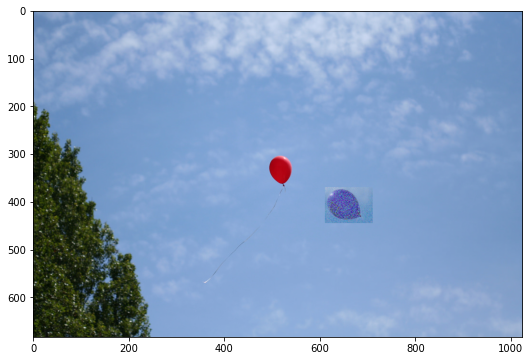

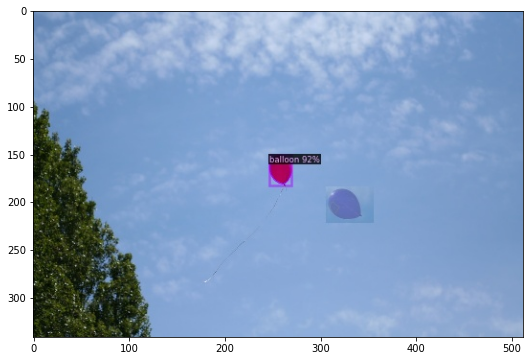

In [34]:
########### Baloon Image ##############
path1 = '/home/prajwala/images/original.jpg'
path2 = '/home/prajwala/images/balloon2.jpg'
patch = [610,370,710,445]
init_alpha = torch.rand(size=(75,100,3))
y1,y2,x1,x2 = [370,445,610,710]

alpha_history = train_blendnet(path1, path2, patch, init_alpha,y1,y2,x1,x2)

model = BlendNet(alpha=alpha_history[-1])


img_fg = Image.open(path2)
img_bg = Image.open(path1)
# Convert to tensor and change dtype
tr = transforms.Lambda(lambda img: torch.from_numpy(np.array(img).astype(np.float32)))
img_fg = tr(img_fg)
img_bg = tr(img_bg)
result = model(img_bg, img_fg,y1,y2,x1,x2)
fig = figure(figsize=(10,6))
plt.imshow(result.detach().numpy().astype(np.uint8))

cv2.imwrite('/home/prajwala/images/blended_images/blendnet_out.jpg',result.detach().numpy().astype(np.uint8))
view_detectron_results('/home/prajwala/images/blended_images/blendnet_out.jpg', 'baloons1')


In [40]:
print(alpha_tensor == alpha_history[-2])

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        ...,

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
       

In [33]:
print(alpha_history[-1] == init_alpha)

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        ...,

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
       

<class 'torch.Tensor'>
/home/prajwala/images/detectron_results/blendnet/baloons.jpg


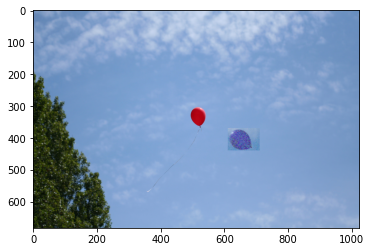

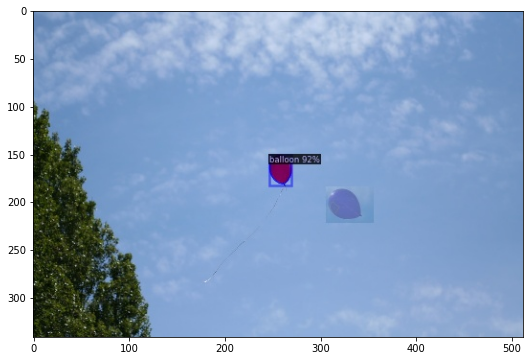

## CV2 blending without torch

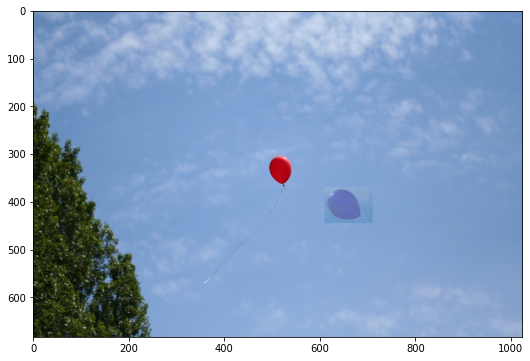

In [56]:
src1 = cv2.imread('/home/prajwala/images/balloon2.jpg')
src2 = cv2.imread('/home/prajwala/images/original.jpg')
src1 = cv2.resize(src1, (src2.shape[1],src2.shape[0]), interpolation = cv2.INTER_AREA)
A = np.array(src1, dtype=np.float32)
B = np.array(src2, dtype=np.float32)

alpha_reduced = np.ones((75,100,3), dtype=np.float32)* 0.35

temp = A[370:445,610:710]*alpha_reduced + B[370:445,610:710] * (1.0-alpha_reduced)
B[370:445,610:710] = temp
cv2.imwrite('/home/prajwala/images/blended_images/blended_img.jpg',B)
img = cv2.imread("/home/prajwala/images/blended_images/blended_img.jpg")
# cv2.imshow("image", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
fig = figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

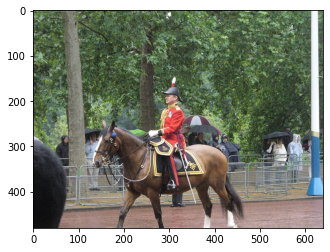

In [35]:
src1 = cv2.imread('/home/prajwala/images/horse_man.jpg')
plt.imshow(cv2.cvtColor(src1, cv2.COLOR_BGR2RGB))
plt.show()

(640, 428, 3)
(480, 640, 3)


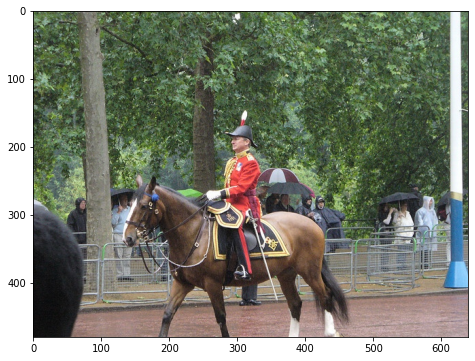

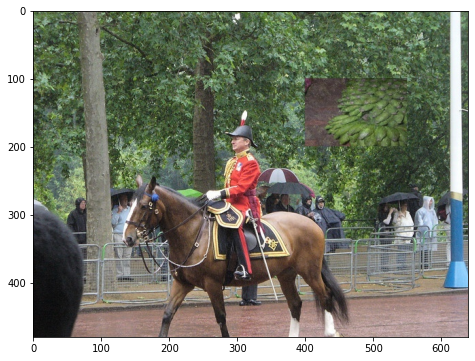

In [82]:
src2 = cv2.imread('/home/prajwala/images/horse_man.jpg')
src1 = cv2.imread('/home/prajwala/images/green_banana.jpg')
print(src1.shape)
print(src2.shape)


fig = figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(src2, cv2.COLOR_BGR2RGB))
plt.show()

src1 = cv2.resize(src1, (150,100), interpolation = cv2.INTER_AREA)

# fig = figure(figsize=(10,6))
# plt.imshow(cv2.cvtColor(src1, cv2.COLOR_BGR2RGB))
# plt.show()
A = np.array(src1, dtype=np.float32)
B = np.array(src2, dtype=np.float32)

alpha_reduced = np.ones((100,150,3), dtype=np.float32)* 0.65

temp = A*alpha_reduced + B[100:200,400:550] * (1.0-alpha_reduced)
B[100:200,400:550] = temp
cv2.imwrite('/home/prajwala/images/blended_images_vanilla/blended_img_2.jpg',B)
img = cv2.imread("/home/prajwala/images/blended_images_vanilla/blended_img_2.jpg")
# # cv2.imshow("image", img)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
fig = figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

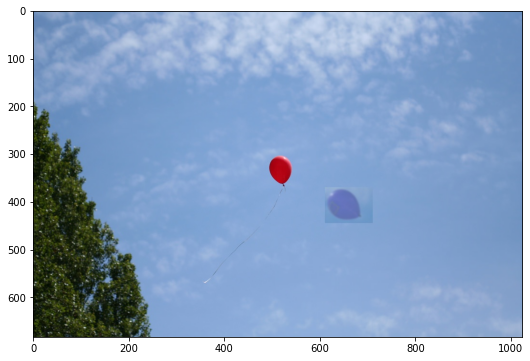

In [58]:
src1 = cv2.imread('/home/prajwala/images/balloon2.jpg')
src2 = cv2.imread('/home/prajwala/images/original.jpg')
src1 = cv2.resize(src1, (src2.shape[1],src2.shape[0]), interpolation = cv2.INTER_AREA)
A = np.array(src1, dtype=np.float32)
B = np.array(src2, dtype=np.float32)

alpha_reduced = np.ones((75,100,3), dtype=np.float32)* 0.340

temp = A[370:445,610:710]*alpha_reduced + B[370:445,610:710] * (1.0-alpha_reduced)

temp_blur = cv2.GaussianBlur(temp,(7,7),0)
B[370:445,610:710] = temp_blur

cv2.imwrite('/home/prajwala/images/blended_images/gaussian_blended_img.jpg',B)
gaussian_img = cv2.imread("/home/prajwala/images/blended_images/gaussian_blended_img.jpg")

fig = figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(gaussian_img, cv2.COLOR_BGR2RGB))
plt.show()

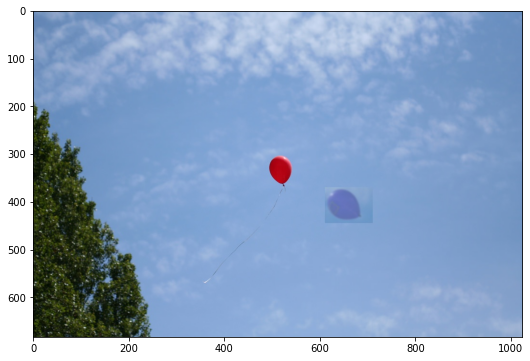

In [59]:
src1 = cv2.imread('/home/prajwala/images/balloon2.jpg')
src2 = cv2.imread('/home/prajwala/images/original.jpg')
src1 = cv2.resize(src1, (src2.shape[1],src2.shape[0]), interpolation = cv2.INTER_AREA)
A = np.array(src1, dtype=np.float32)
B = np.array(src2, dtype=np.float32)

alpha_reduced = np.ones((75,100,3), dtype=np.float32)* 0.340

temp = A[370:445,610:710]*alpha_reduced + B[370:445,610:710] * (1.0-alpha_reduced)

temp_blur = cv2.GaussianBlur(temp,(7,7),0)
B[370:445,610:710] = temp_blur

# filter whole image using bilateral filter
B_filtered = cv2.bilateralFilter(B,3,9,9)

cv2.imwrite('/home/prajwala/images/blended_images/bilateral_blended_img.jpg',B)
bilateral_img = cv2.imread("/home/prajwala/images/blended_images/bilateral_blended_img.jpg")

fig = figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(bilateral_img, cv2.COLOR_BGR2RGB))
# plt.imshow(bilateral_img)

# Test Attack on Detectron

In [21]:
# # install dependencies: 
# !pip install pyyaml==5.1
import torch, torchvision
print(torchvision.__version__)
print(torch.__version__, torch.cuda.is_available())
# !gcc --version

0.8.1
1.7.0 True


In [22]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
# !cd
# !pwd
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [23]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [24]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

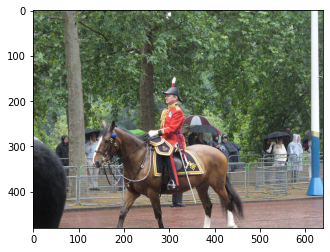

In [25]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
# cv2.waitKey(20)
# cv2.destroyAllWindows()

In [26]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

## Test attack on vanilla detectron

/home/prajwala/images/detectron_results/vanilla/blended_img_2.jpg


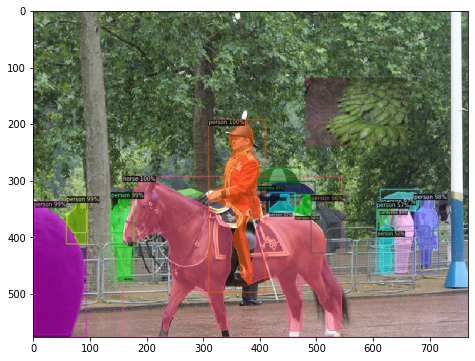

In [27]:
horse_man_crow = cv2.imread("/home/prajwala/images/blended_images_vanilla/blended_img_2.jpg")
outputs = predictor(horse_man_crow)

v = Visualizer(horse_man_crow[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite('/home/prajwala/images/detectron_results/vanilla/blended_img_2.jpg',out.get_image()[:, :, ::-1])
    
path2 = '/home/prajwala/images/detectron_results/vanilla/*.*'
for file in glob.glob(path2):
    res = cv2.imread(file)
    fig = figure(figsize=(10,6))
    print(file)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.show()

In [28]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2.imshow("image",out.get_image()[:, :, ::-1])

In [29]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

## Train on custom dataset

In [30]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

## Train

In [13]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/29 13:12:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/29 13:12:48 d2.engine.train_loop]: Starting training from iteration 0
[03/29 13:13:10 d2.utils.events]:  eta: 0:05:02  iter: 19  total_loss: 2.001  loss_cls: 0.5994  loss_box_reg: 0.6277  loss_mask: 0.6968  loss_rpn_cls: 0.04479  loss_rpn_loc: 0.008088  time: 1.0797  data_time: 0.0180  lr: 4.9953e-06  max_mem: 2849M
[03/29 13:13:30 d2.utils.events]:  eta: 0:04:25  iter: 39  total_loss: 2.024  loss_cls: 0.5858  loss_box_reg: 0.7144  loss_mask: 0.6678  loss_rpn_cls: 0.0319  loss_rpn_loc: 0.009753  time: 1.0408  data_time: 0.0035  lr: 9.9902e-06  max_mem: 2849M
[03/29 13:13:51 d2.utils.events]:  eta: 0:04:07  iter: 59  total_loss: 1.782  loss_cls: 0.5244  loss_box_reg: 0.5268  loss_mask: 0.6128  loss_rpn_cls: 0.03715  loss_rpn_loc: 0.01028  time: 1.0334  data_time: 0.0039  lr: 1.4985e-05  max_mem: 2849M
[03/29 13:14:12 d2.utils.events]:  eta: 0:03:51  iter: 79  total_loss: 1.694  loss_cls: 0.4699  loss_box_reg: 0.5935  loss_mask: 0.5299  loss_rpn_cls: 0.0446  loss_rpn_loc: 0.006643  t

In [14]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [15]:
import pickle
filename = '/home/prajwala/DetectronExperiments/myvenv/saved_models/trained_detectron.sav'
pickle.dump(predictor, open(filename, 'wb'))

In [4]:
import pickle
filename = '/home/prajwala/DetectronExperiments/myvenv/saved_models/trained_detectron.sav'
loaded_predictor = pickle.load(open(filename, 'rb'))

tensor([[517.3998, 334.9943],
        [651.5109, 409.8480]], device='cuda:0')
tensor([[517.2820, 335.0325]], device='cuda:0')
tensor([[517.3998, 334.9943],
        [651.5109, 409.8480]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2))
tensor([[517.4008, 334.9964],
        [645.1682, 406.0385]], device='cuda:0')
/home/prajwala/images/detectron_results/original.jpg


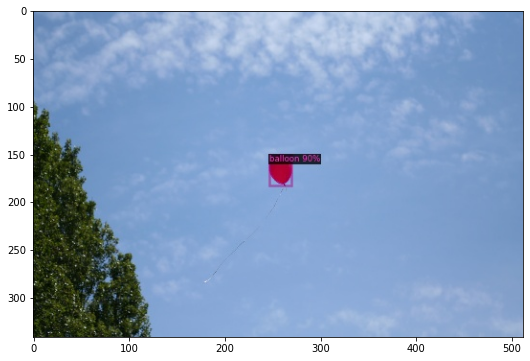

/home/prajwala/images/detectron_results/gaussian_blended_img.jpg


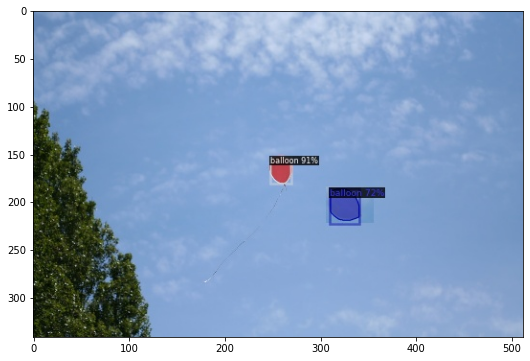

/home/prajwala/images/detectron_results/balloon2.jpg


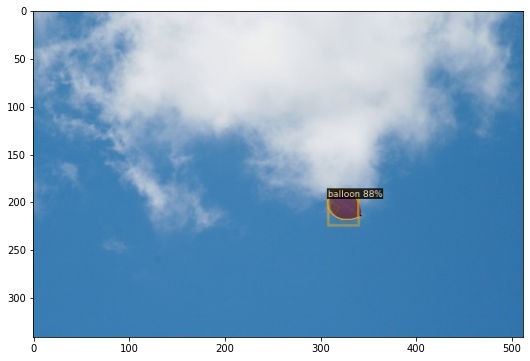

/home/prajwala/images/detectron_results/blendnet_out.jpg


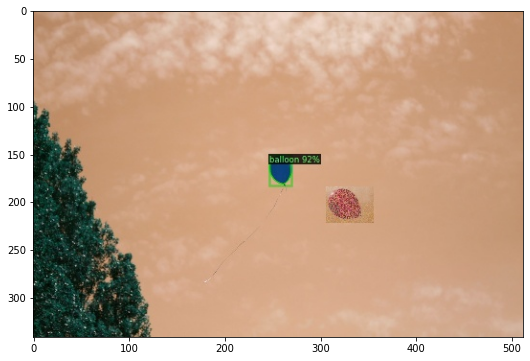

/home/prajwala/images/detectron_results/bilateral_blended_img.jpg


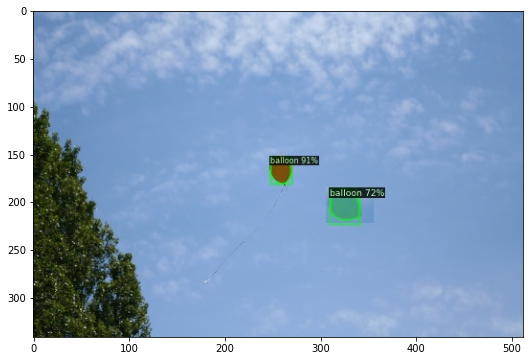

/home/prajwala/images/detectron_results/blended_img_2.jpg


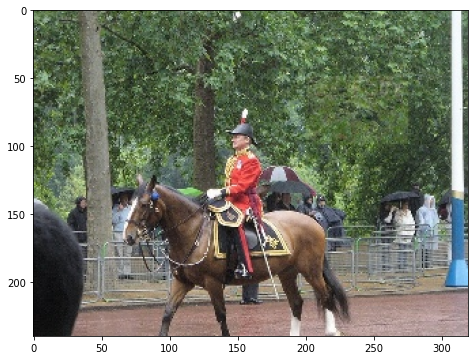

/home/prajwala/images/detectron_results/blended_img.jpg


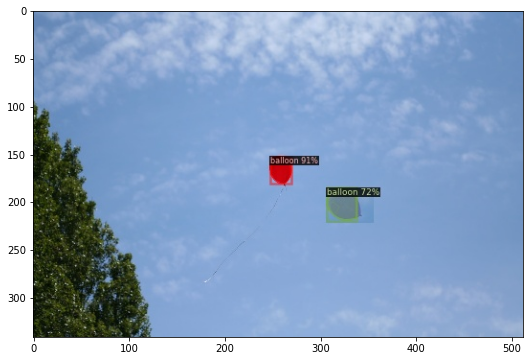

In [31]:
import glob
from detectron2.utils.visualizer import ColorMode
path = '/home/prajwala/images/blended_images/*.*'
for file in glob.glob(path):
  im = cv2.imread(file)
  # cv2_imshow(im)
  
  outputs = loaded_predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#   print(type(outputs["instances"]))
    # pred_boxes is a tensor (Tensor[float]) – a Nx4 matrix. Each row is (x1, y1, x2, y2).
  print(outputs["instances"].get('pred_boxes').get_centers())
#   print(outputs["instances"].scores)
#   print(outputs["instances"].proposal_boxes)
  # print(outputs["instances"].objectness_logits)
  v = Visualizer(im[:, :, ::-1],
                  metadata=balloon_metadata, 
                  scale=0.5, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#   cv2_imshow(out.get_image()[:, :, ::-1])
  cv2.imwrite('/home/prajwala/images/detectron_results/'+os.path.basename(file),out.get_image()[:, :, ::-1])
    
path2 = '/home/prajwala/images/detectron_results/*.*'
for file in glob.glob(path2):
    res = cv2.imread(file)
    fig = figure(figsize=(10,6))
    print(file)
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    plt.show()